In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import pathlib

In [3]:
tf.__version__

'2.7.0'

In [4]:
%run module.ipynb

## Data preprocessing

In [5]:
BATCH_SIZE = 32

In [6]:
image_input = sorted(tf.io.gfile.glob('./ISIC2018_Task1-2_Training_Input_x2/*.jpg'))
ground_truth = sorted(tf.io.gfile.glob('./ISIC2018_Task1_Training_GroundTruth_x2/*.png'))

In [7]:
image_input[:3]

['.\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0000000.jpg',
 '.\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0000001.jpg',
 '.\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0000003.jpg']

In [8]:
ground_truth[:3]

['.\\ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0000000_segmentation.png',
 '.\\ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0000001_segmentation.png',
 '.\\ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0000003_segmentation.png']

In [9]:
index = np.random.permutation(len(image_input))
image_input = np.array(image_input)[index]
ground_truth = np.array(ground_truth)[index]

In [10]:
image_input[:3]

array(['.\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0010598.jpg',
       '.\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0011374.jpg',
       '.\\ISIC2018_Task1-2_Training_Input_x2\\ISIC_0014183.jpg'],
      dtype='<U53')

In [11]:
ground_truth[:3]

array(['.\\ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0010598_segmentation.png',
       '.\\ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0011374_segmentation.png',
       '.\\ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0014183_segmentation.png'],
      dtype='<U70')

In [12]:
# Divide the dataset into training set, test set and val set with 6：2：2
length = len(image_input)
print(length)

image_input_val = image_input[:(int(length*0.2))]
print(len(image_input_val))
ground_truth_val = ground_truth[:(int(length*0.2))]
print(len(ground_truth_val))

2594
518
518


In [13]:
image_input_test = image_input[int(length*0.2):int(length*0.3)]
ground_truth_test = ground_truth[int(length*0.2):int(length*0.3)]

image_input_train = image_input[int(length*0.3):]
ground_truth_train = ground_truth[int(length*0.3):]

In [14]:
print(len(image_input_train))
print(len(ground_truth_train))

1816
1816


In [15]:
# To re-import train_ds, you need to start from this step
train_ds = tf.data.Dataset.from_tensor_slices((image_input_train, ground_truth_train))
val_ds = tf.data.Dataset.from_tensor_slices((image_input_val, ground_truth_val))
test_ds = tf.data.Dataset.from_tensor_slices((image_input_test, ground_truth_test))

In [16]:
# Image processing function
# Limited by the  memory of the GPU, choose the image size of 192, 192
def processing_jpg(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (192, 256))
    
    return image
  
def processing_png(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, (192, 256))
    
    return image

In [17]:
# normalize function
def normal(image, ground):
    image = tf.cast(image, tf.float32) / 255.0
    ground = tf.cast(ground, tf.float32) / 255.0
    
    return image, ground

def load_image(image_path, ground_path):
    image = processing_jpg(image_path)
    ground = processing_png(ground_path)
    image, ground = normal(image, ground)

    return image, ground

In [18]:
train_ds = train_ds.map(load_image)
val_ds = val_ds.map(load_image)
test_ds = test_ds.map(load_image)

In [19]:
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [20]:
test_ds

<BatchDataset shapes: ((None, 192, 256, 3), (None, 192, 256, 1)), types: (tf.float32, tf.float32)>

## Construct related functions

In [21]:
def dice_coef(y_true, y_pred, smooth = 1.0):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice_coef_result = (2.0 * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

    return dice_coef_result

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [22]:
def plot_dice_and_loss(history):
    dice = history.history['dice_coef']
    val_dice = history.history['val_dice_coef']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(20)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, dice, label='Training Dice')
    plt.plot(epochs_range, val_dice, label='Validation Dice')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Dice Coefficient')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [23]:
def plot_prediction_images(model, test_ds, n = 3):
    X_test, y_test = next(iter(test_ds))
    y_pred = model.predict(X_test)
    
    FONT_SIZE = 18
    
    plt.figure(figsize=(14, 14))
    for i in range(n):
        plt.subplot(n, 3, i*3+1)
        plt.imshow(X_test[i])
        plt.axis('off')
        plt.title("Image", size=FONT_SIZE)

        plt.subplot(n, 3, i*3+2)

        plt.imshow(y_pred[i])
        plt.axis('off')
        plt.title("Prediction", size=FONT_SIZE)

        plt.subplot(n, 3, i*3+3)
        plt.imshow(y_test[i])
        plt.axis('off')
        plt.title("Original_Result", size=FONT_SIZE)
    plt.show()

## Compile and train the model

In [24]:
model = improved_model()
model.compile(optimizer="adam", loss=dice_coef_loss, metrics=[dice_coef])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 instance_normalization (Instan  (None, 192, 256, 16  32         ['conv2d[0][0]']                 
 ceNormalization)               )                                                             

In [26]:
history = model.fit(train_ds, validation_data = val_ds, epochs = 20)

Epoch 1/20
57/57 [==============================] - 22s 262ms/step - loss: 0.5529 - dice_coef: 0.4475 - val_loss: 0.4335 - val_dice_coef: 0.5668
Epoch 2/20
57/57 [==============================] - 13s 221ms/step - loss: 0.3728 - dice_coef: 0.6275 - val_loss: 0.2950 - val_dice_coef: 0.7046
Epoch 3/20
57/57 [==============================] - 14s 237ms/step - loss: 0.2512 - dice_coef: 0.7489 - val_loss: 0.2041 - val_dice_coef: 0.7961
Epoch 4/20
57/57 [==============================] - 15s 259ms/step - loss: 0.1904 - dice_coef: 0.8097 - val_loss: 0.1835 - val_dice_coef: 0.8155
Epoch 5/20
57/57 [==============================] - 15s 259ms/step - loss: 0.1683 - dice_coef: 0.8319 - val_loss: 0.1819 - val_dice_coef: 0.8169
Epoch 6/20
57/57 [==============================] - 15s 259ms/step - loss: 0.1561 - dice_coef: 0.8438 - val_loss: 0.1493 - val_dice_coef: 0.8493
Epoch 7/20
57/57 [==============================] - 15s 259ms/step - loss: 0.1466 - dice_coef: 0.8534 - val_loss: 0.1432 - val_dic

## Test the prediction results and the dice coefficient of the model 

In [27]:
plot_dice_and_loss(history

SyntaxError: unexpected EOF while parsing (544878543.py, line 1)

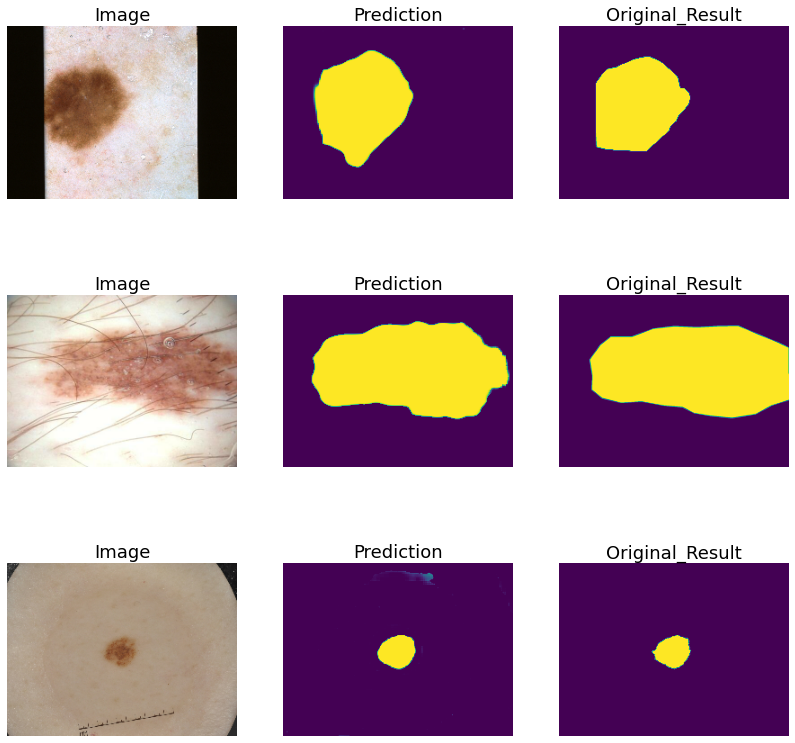

In [28]:
plot_prediction_images(model, test_ds)

In [29]:
pred_result = model.evaluate(test_ds, verbose=1)

9/9 [==============================] - 1s 94ms/step - loss: 0.1352 - dice_coef: 0.8528
